In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import math

%matplotlib inline

In [2]:
# load words
words = open("names.txt").read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
DELIMITER = "."
chars = sorted(set(list("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi.update({".": 0})
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)


# pretty print
skip_index = 27
items = [(i, itos.get(i)) for i in range(len(itos)) if i != skip_index]

first_col = items[: len(items) // 2 + len(items) % 2]
second_col = items[len(items) // 2 + len(items) % 2 :]

for first, second in zip(first_col, second_col + [(None, None)]):
    first_str = f"{first[0]:>2} -> {first[1]}"
    second_str = f"{second[0]:>2} -> {second[1]}" if second[0] is not None else ""
    print(f"{first_str}\t\t{second_str}")

 0 -> .		14 -> n
 1 -> a		15 -> o
 2 -> b		16 -> p
 3 -> c		17 -> q
 4 -> d		18 -> r
 5 -> e		19 -> s
 6 -> f		20 -> t
 7 -> g		21 -> u
 8 -> h		22 -> v
 9 -> i		23 -> w
10 -> j		24 -> x
11 -> k		25 -> y
12 -> l		26 -> z
13 -> m		


Build the dataset

In [4]:
# architecture
CONTEXT_LENGTH = 4
N_EMBEDDINGS = 12
N_HIDDEN = 1024
# training
BATCH_SIZE = 64
EPOCHS = 300_000
LR_START = 0.3
LR_END = 0.001
K = 9  # LR decay rate

random.seed(42)
random.shuffle(words)  # shuffles in place


def build_dataset(words: list[str]) -> tuple[torch.Tensor, torch.Tensor]:
    X, Y = [], []

    for word in words:
        context = [0] * CONTEXT_LENGTH
        for char in word + DELIMITER:
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


splits = int(0.8 * len(words)), int(0.9 * len(words))

X_train, Y_train = build_dataset(words[: splits[0]])
X_dev, Y_dev = build_dataset(words[splits[0] : splits[1]])
X_test, Y_test = build_dataset(words[splits[1] :])

torch.Size([182625, 4]) torch.Size([182625])
torch.Size([22655, 4]) torch.Size([22655])
torch.Size([22866, 4]) torch.Size([22866])


In [5]:
g = torch.Generator().manual_seed(2147483647)
kaiming_init = (5 / 3) / (N_EMBEDDINGS * CONTEXT_LENGTH) ** 0.5
# Tensors
C = torch.randn([vocab_size, N_EMBEDDINGS], generator=g)
W1 = torch.randn([N_EMBEDDINGS * CONTEXT_LENGTH, N_HIDDEN], generator=g) * kaiming_init
b1 = torch.randn([N_HIDDEN], generator=g) * 0.01
W2 = torch.randn([N_HIDDEN, vocab_size], generator=g) * 0.01
b2 = torch.randn([vocab_size], generator=g) * 0.01

# normalization gain and shift
batch_norm_gain = torch.ones([1, N_HIDDEN])
batch_norm_bias = torch.zeros([1, N_HIDDEN])

parameters = [C, W1, b1, W2, b2, batch_norm_gain, batch_norm_bias]

# add gradients
for p in parameters:
    p.requires_grad = True

In [6]:
print(f"Number of parameters in model: {sum(p.nelement() for p in parameters):,}")

Number of parameters in model: 80,223


Training

In [7]:
lri = []
lossi = []
stepi = []

for i in range(EPOCHS):
    batch_indices = torch.randint(0, X_train.shape[0], (BATCH_SIZE,))

    # forward pass
    embeddings = C[X_train[batch_indices]]
    h_pre_activation = embeddings.view(-1, N_EMBEDDINGS * CONTEXT_LENGTH) @ W1 + b1
    h_pre_activation_norm = (
        batch_norm_gain
        * (h_pre_activation - h_pre_activation.mean(0, keepdim=True))
        / h_pre_activation.std(0, keepdim=True)
    ) + batch_norm_bias
    h = torch.tanh(h_pre_activation_norm)
    if i == 0:
        h_i1 = h
        print("Saved first `h` tensor")
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[batch_indices])

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = LR_END + (LR_START - LR_END) * math.exp(-K * (i / EPOCHS))
    for p in parameters:
        p.data += -lr * p.grad

    # tracking
    stepi.append(i)
    lri.append(lr)
    lossi.append(loss.item())

    if (i % (EPOCHS // 10) == 0) | (i == EPOCHS - 1):
        print(
            f"Epoch {i:6}: loss = {loss:6f}, lr = {lr:.6f}, % of tanh values saturated = {(h.abs() > 0.99).float().mean().item():.6f}"
        )

Saved first `h` tensor
Epoch      0: loss = 3.275609, lr = 0.300000, % of tanh values saturated = 0.009567
Epoch  30000: loss = 1.951928, lr = 0.122564, % of tanh values saturated = 0.006470
Epoch  60000: loss = 1.993474, lr = 0.050424, % of tanh values saturated = 0.013870
Epoch  90000: loss = 2.219589, lr = 0.021094, % of tanh values saturated = 0.016769
Epoch 120000: loss = 1.962524, lr = 0.009170, % of tanh values saturated = 0.016968
Epoch 150000: loss = 2.058014, lr = 0.004322, % of tanh values saturated = 0.017502
Epoch 180000: loss = 1.576630, lr = 0.002350, % of tanh values saturated = 0.018600
Epoch 210000: loss = 1.896502, lr = 0.001549, % of tanh values saturated = 0.019028
Epoch 240000: loss = 1.772595, lr = 0.001223, % of tanh values saturated = 0.020615
Epoch 270000: loss = 1.845596, lr = 0.001091, % of tanh values saturated = 0.019257
Epoch 299999: loss = 1.752936, lr = 0.001037, % of tanh values saturated = 0.020294


---
Analyzing `h` (tanh) distribution

(array([1364., 1487., 1445., 1385., 1426., 1389., 1198., 1290., 1242.,
        1198., 1146., 1075., 1082., 1085., 1029., 1026.,  927.,  984.,
         984., 1017., 1018.,  874.,  928.,  975.,  918.,  949.,  934.,
         869.,  889.,  890.,  856., 1063.,  843.,  909.,  897.,  864.,
         906.,  887.,  899.,  958.,  937.,  957., 1027.,  916.,  947.,
        1033., 1008., 1047., 1057., 1072., 1164., 1192., 1178., 1273.,
        1369., 1354., 1396., 1440., 1587., 1477.]),
 array([-9.99813557e-01, -9.66485862e-01, -9.33158167e-01, -8.99830472e-01,
        -8.66502778e-01, -8.33175083e-01, -7.99847388e-01, -7.66519694e-01,
        -7.33191999e-01, -6.99864304e-01, -6.66536609e-01, -6.33208915e-01,
        -5.99881220e-01, -5.66553525e-01, -5.33225830e-01, -4.99898136e-01,
        -4.66570441e-01, -4.33242746e-01, -3.99915051e-01, -3.66587357e-01,
        -3.33259662e-01, -2.99931967e-01, -2.66604273e-01, -2.33276578e-01,
        -1.99948883e-01, -1.66621188e-01, -1.33293494e-01, -9.9965

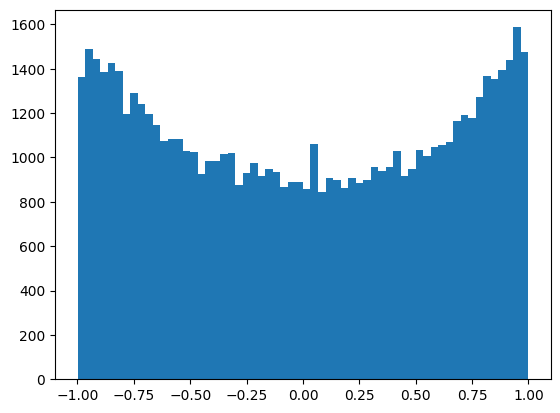

In [17]:
plt.hist(h_i1.view(-1).tolist(), 60)

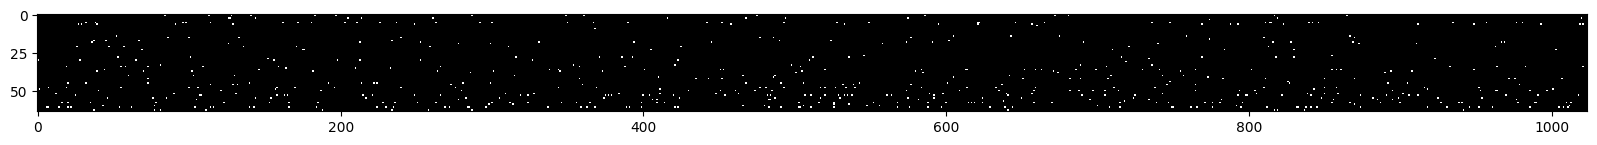

In [18]:
plt.figure(figsize=(20, 10))
plt.imshow(h_i1.abs() > 0.99, cmap="grey", interpolation="nearest")

---

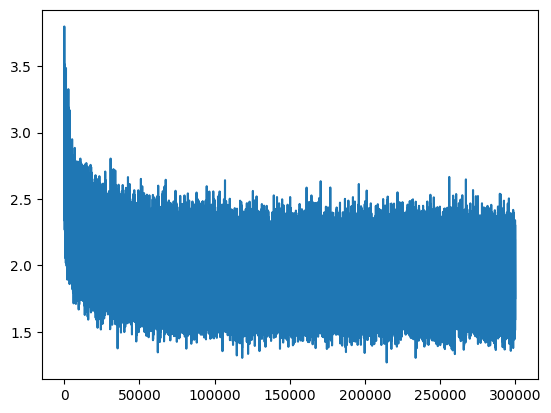

In [19]:
plt.plot(stepi, lossi)

Calibrate batch norm at end of training

In [20]:
with torch.no_grad():
    embeddings = C[X_train]
    h_pre_activation = embeddings.view(-1, N_EMBEDDINGS * CONTEXT_LENGTH) @ W1 + b1
    batch_norm_mean = h_pre_activation.mean(0, keepdim=True)
    batch_norm_std = h_pre_activation.std(0, keepdim=True)

In [21]:
# loss on whole training set
embeddings = C[X_train]
h_pre_activation = embeddings.view(-1, N_EMBEDDINGS * CONTEXT_LENGTH) @ W1 + b1
h_pre_activation_norm = (
    batch_norm_gain * ((h_pre_activation - batch_norm_mean) / batch_norm_std)
    + batch_norm_bias
)
h = torch.tanh(h_pre_activation_norm)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
print(loss)

tensor(1.8630, grad_fn=<NllLossBackward0>)


In [22]:
# loss on dev set
embeddings = C[X_dev]
h_pre_activation = embeddings.view(-1, N_EMBEDDINGS * CONTEXT_LENGTH) @ W1 + b1
h_pre_activation_norm = (
    batch_norm_gain * ((h_pre_activation - batch_norm_mean) / batch_norm_std)
    + batch_norm_bias
)
h = torch.tanh(h_pre_activation_norm)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_dev)
print(loss)

tensor(2.0165, grad_fn=<NllLossBackward0>)


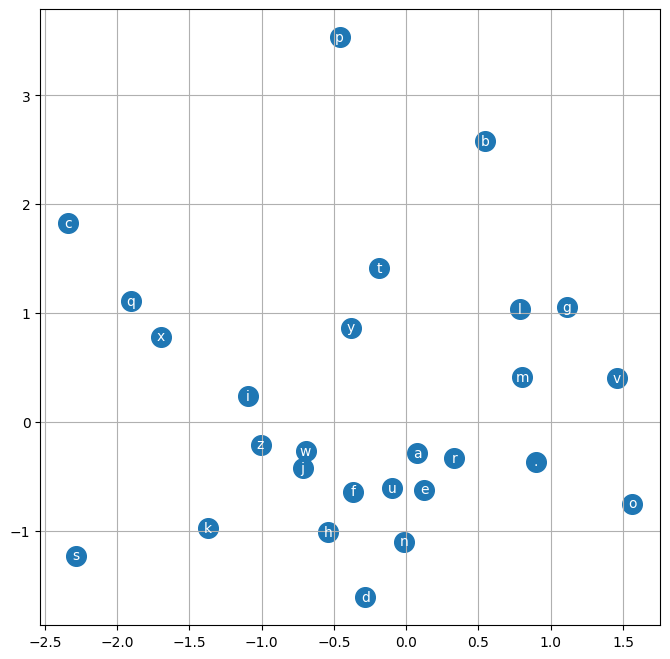

In [23]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(
        C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white"
    )
plt.grid("minor")

Sample

In [24]:
g = torch.Generator().manual_seed(2147483647 + 10)
generated_names = []

for _ in range(20):
    out = []
    context = [0] * CONTEXT_LENGTH
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h_pre_activation = emb.view(-1, N_EMBEDDINGS * CONTEXT_LENGTH) @ W1 + b1
        h_pre_activation_norm = (
            batch_norm_gain * ((h_pre_activation - batch_norm_mean) / batch_norm_std)
            + batch_norm_bias
        )
        h = torch.tanh(h_pre_activation_norm)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    generated_names.append("".join(itos[i] for i in out))
for name in generated_names:
    print(name)

montay.
yazziee.
madhayah.
reise.
jendrien.
adelyn.
eliah.
milopa.
edelisanana.
septy.
malaia.
noshub.
ridhira.
stel.
joselynn.
novalen.
brenddi.
kyler.
mehs.
kayshawn.


In [25]:
[w for w in generated_names if w[:-1] in words]

['montay.',
 'reise.',
 'adelyn.',
 'eliah.',
 'malaia.',
 'joselynn.',
 'kyler.',
 'kayshawn.']